In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import *

import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 2

In [2]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.
perc_step = 5

In [3]:
# read  data
path_data = '/saturn/simu_Caribbean/forced_3km/CNT/FEB/01/'
wrf_files = path_data + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))
ds_for = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [4]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
# select domain
mask_lon = (ds_for.XLONG >= minlon) & (ds_for.XLONG <= maxlon)
mask_lat = (ds_for.XLAT >= minlat) & (ds_for.XLAT <= maxlat)
ds_for = ds_for.where(mask_lon & mask_lat, drop=True)

In [5]:
# def lon lat time
lon_ff = ds_for['XLONG'][0].values
lat_ff = ds_for['XLAT'][0].values
time = ds_for['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds_for['LAKEMASK'][0].values
landmask = ds_for['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()
del seamask_nocoast, lakemask, landmask

In [6]:

GPH_base = ds_for['PHB']/9.81  

GPH = ds_for['PH']/9.81   #.sel(XTIME=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))/9.81


GPH = GPH_base + GPH
# GPH = GPH.transpose('XTIME', 'lev_W', 'y_grid_M', 'x_grid_M')
# GPH = GPH.where(sea_mask_modified, drop=False)

GPH = GPH[::3, 0:30, :,:]   ## making 3h 

del GPH_base
# del ds_for

In [7]:
QCLOUD = ds_for['QCLOUD']
QCLOUD = QCLOUD[::3, 0:29, :,:]

<xarray.DataArray (Time: 695, bottom_top_stag: 75, south_north: 446, west_east: 323)>
dask.array<add, shape=(695, 75, 446, 323), dtype=float32, chunksize=(1, 75, 446, 323), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 446, 323), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 446, 323), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top_stag, south_north, west_east

In [12]:
press_from_GPH = mpcalc.height_to_pressure_std(GPH.values*units.meters)
del GPH

In [15]:
press_diff = np.zeros_like(QCLOUD.values)
press_diff = press_from_GPH[:,0:-1,:,:] - press_from_GPH[:,1:,:,:] 
del press_from_GPH

In [48]:
press_diff = xr.DataArray(press_diff, name='press_diff', dims=['Time', 'bottom_top', 'south_north', 'west_east'])
press_diff.attrs['long name'] = 'pressure difference up to 30th GPH level, forced simulation'
press_diff.attrs['units'] = 'metres [m]'

press_diff.to_netcdf('/venus/tesi_ale/data_EU/FORCED_GPH/press_diff_forced.nc')

In [ ]:
press_diff = xr.open_dataset('/venus/tesi_ale/data_EU/FORCED_GPH/press_diff_forced.nc')

In [16]:
qcloud_percell = (QCLOUD*1000.)*press_diff.magnitude/9.81
del press_diff

In [17]:
qcloud_percell

<xarray.DataArray 'QCLOUD' (Time: 232, bottom_top: 29, south_north: 446, west_east: 323)>
dask.array<truediv, shape=(232, 29, 446, 323), dtype=float32, chunksize=(1, 29, 446, 323), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 446, 323), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 446, 323), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, south_north, west_east

In [8]:
qcloud_percell = xr.open_dataset('/venus/tesi_ale/data_EU/FORCED_GPH/qcloud_percell.nc')

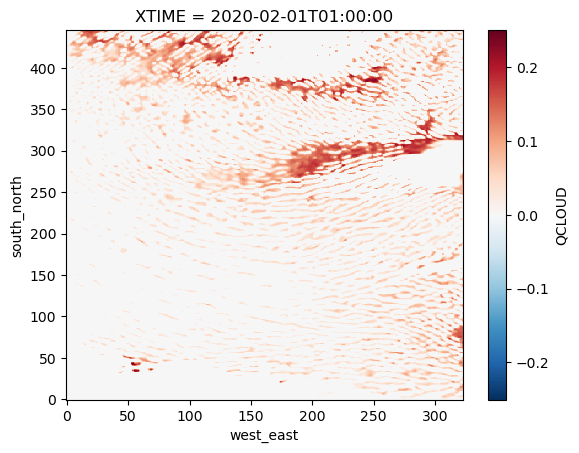

In [18]:
qcloud_percell[0,20].plot()

In [19]:
###   RETRIEVE TOTAL PRESSURE 

# pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = ds_for['PB']

pres = ds_for['P'] #xr.open_dataset(wrf_files[files_ls.index('P.nc')])
# pres = pres['P'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))


pres = (pres+pres_base)/100.                # hectoPascals

pres = pres[::3, 0:29,:,:]

del pres_base

In [20]:
LWP_lowTropo = qcloud_percell.where(pres>=800.).sum(dim='bottom_top')  #*sea_mask_modified_nan
# LWP_total = qcloud_percell.sum(dim='bottom_top')

In [21]:
LWP_lowTropo

<xarray.DataArray 'QCLOUD' (Time: 232, south_north: 446, west_east: 323)>
dask.array<sum-aggregate, shape=(232, 446, 323), dtype=float32, chunksize=(1, 446, 323), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 446, 323), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 446, 323), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east

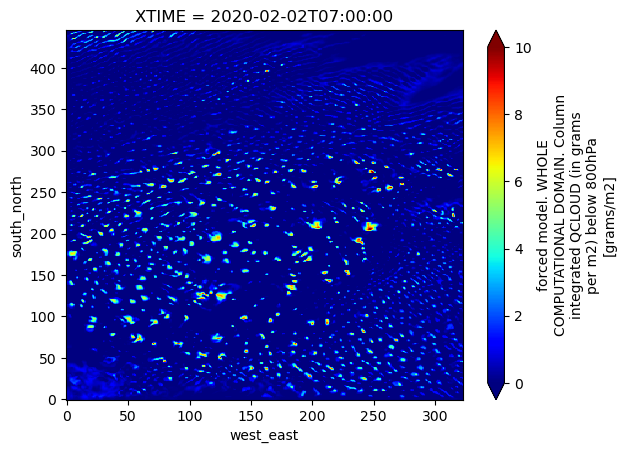

In [12]:
LWP_lowTropo_xarr[10].plot(vmin=0, vmax=10, cmap='jet')

In [72]:
qcloud_percell.name='qcloud_percell'
qcloud_percell.attrs['long_name'] = 'forced model. WHOLE COMPUTATIONAL DOMAIN. Grams of liquid cloud water in every gridbox; I used GPH-derived pressure'
qcloud_percell.attrs['units'] = 'g/m2'


ds_cloudz = xr.Dataset({'qcloud_percell':qcloud_percell})
ds_cloudz.to_netcdf('/venus/tesi_ale/data_EU/FORCED_GPH/qcloud_percell.nc')



### NON LI SALVA LO STR****ENZO

KeyboardInterrupt: 

In [24]:
LWP_lowTropo.name = 'LWP_lowTropo'
LWP_lowTropo.attrs['long_name'] = 'forced model. WHOLE COMPUTATIONAL DOMAIN. Column integrated QCLOUD (in grams per m2) below 800hPa'
LWP_lowTropo.attrs['units'] = 'grams/m2'

In [25]:
ds_low = xr.Dataset({'LWP_lowTropo': LWP_lowTropo})

In [26]:
ds_low.to_netcdf('/venus/tesi_ale/data_EU/FORCED_GPH/LWP_lowTropo.nc')

### time series and maps

In [31]:
LWP_lowTropo_xarr = xr.DataArray(LWP_lowTropo)

In [ ]:
## snapshots

In [8]:
ds_lwp = xr.open_dataset('/venus/tesi_ale/data_EU/FORCED_GPH/LWP_lowTropo.nc')
LWP_lowTropo_xarr = ds_lwp['LWP_lowTropo'] #.groupby('Time.day').mean()


    

In [13]:
LWP_lowTropo_xarr_day = np.zeros((29,446,323))

for i in range(29):
    LWP_lowTropo_xarr_day[i] = np.nanmean(LWP_lowTropo_xarr.values[int(i)*8:int(i+1)*8], axis=0)

In [14]:
std_LWP_Low = LWP_lowTropo_xarr.std(dim='Time')       #np.std(LWP_lowTropo.values, axis=0)

In [15]:
LWP_low_50 = np.nanpercentile(LWP_lowTropo_xarr.values*seamask, 50)
frequency_3h = np.sum(LWP_lowTropo_xarr > LWP_low_50, axis=0)*100/232


LWP_low_50_day = np.nanpercentile(LWP_lowTropo_xarr_day*seamask, 50) 
freq_day = np.sum(LWP_lowTropo_xarr_day > LWP_low_50_day, axis=0)*100/29

In [16]:
LWP_low_50_day

0.11014270409941673

In [17]:
seamask_ff_zero = seamask.copy()
seamask_ff_zero = np.where(seamask_ff_zero==1, 1, 0)

Text(0.5, 0, 'lon [$^\\circ$]')

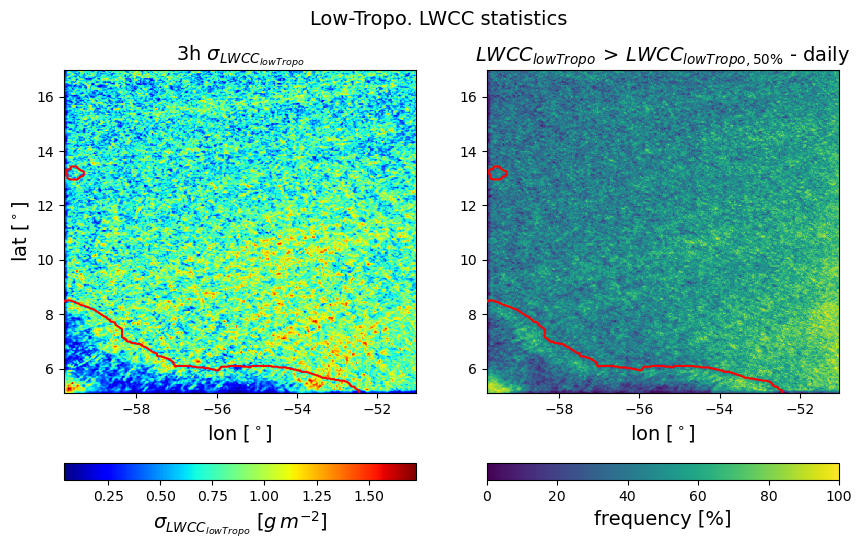

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,6))

fig.suptitle('Low-Tropo. LWCC statistics', fontsize=14)

pcm1 = ax[0].pcolormesh(lon_ff, lat_ff, std_LWP_Low.values, cmap='jet'  ) #, vmin=0.5, vmax=2)
ax[0].contour(lon_ff, lat_ff, seamask_ff_zero, levels=[0.], colors='r', linewidths=1.5, zorder=10, linewidth=2)

cbar1 = plt.colorbar(pcm1, ax=ax[0], location='bottom') #, extend='max')
cbar1.set_label('$\sigma_{LWCC_{lowTropo}}$ [$g\,m^{-2}$]', fontsize=14)
ax[0].set_title('3h $\sigma_{LWCC_{lowTropo}}$', fontsize=14)
ax[0].set_xlabel('lon [$^\circ$]', fontsize=14)
ax[0].set_ylabel('lat [$^\circ$]', fontsize=14)


# Second subplot: sst_std_for
pcm2 = ax[1].pcolormesh(lon_ff, lat_ff, freq_day, cmap='viridis')  #, vmin=0, vmax=100)
ax[1].contour(lon_ff, lat_ff, seamask_ff_zero, levels=[0.], colors='r', linewidths=1.5, zorder=10, linewidth=1.5)
cbar2 = plt.colorbar(pcm2, ax=ax[1], location='bottom') #,  extend='max')
cbar2.set_label('frequency [%]', fontsize=14)
ax[1].set_title('$LWCC_{lowTropo}\,>\,LWCC_{lowTropo, 50\%}$ - daily', fontsize=14)
ax[1].set_xlabel('lon [$^\circ$]', fontsize=14)


# plt.savefig('/venus/tesi_ale/img_EU/time_series/q2_standard_month_couOnly.png')